#  Project Report - Predicting Heart Disease
Group Members: Chengyuan Yao, Eunji Hwang, Lina Anwari, Duffy Du
## Table of Contents:
1. [Introduction](#introduction)
2. [Methods](#methods)
3. [Results](#results)
4. [Discussion](#discussion)
5. [References](#references)


## <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 1.0 Introduction <a id='introduction'></a>

**Background**  
Cardiovascular disease is one of the leading causes of death globally. This disease, also known as heart disease, is linked to several factors such as high cholesterol levels (Calling, 2021), obesity, smoking, and numerous more. To diagnose this disease, a person is tested with stress tests, blood tests, and more to find signs of heart disease to be diagnosed rightfully. 

Using the Heart Disease Data Set, we will be exploring relationships between numerical variables such as age, resting blood pressure, serum cholesterol, maximum heart rate, and ST depression induced by exercise to predict diagnosis. 


**Our Question**  
Based on patients’ vital signs and physiological observations, can we accurately predict whether they have heart disease?

**Variables/Descriptions:**

- age - age in years   

- trestbps - resting blood pressure (mm Hg)

- chol - serum cholesterol (mg/dl)

- thalach - maximum heart rate

- oldpeak - ST depression induced by exercise

**Our Dataset**  
For our classification model, the database we are using is the Heart Disease Data Set. Specifically, we will be analyzing the Cleveland database, which contains information collected by Robert Detrano (M.D., Ph D.) from the Medical Center, Cleveland Clinic Foundation. The data is based on anonymous real-life patients’ records. Each row represents observations of a different patient based on the 14 categories being tested, including the predicted attribute. Using this dataset, we can identify a relationship between predictors and the target variable to determine whether a patient has heart disease.  



## <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.0 Methods <a id='methods'></a>

### 2.1 Importing Data
We first load the libraries used for this project and set the seed number(1234) to use for this project so that our code is reproducible.

In [4]:
#Loaded Libraries

library(tidyverse)
library(repr)
library(tidymodels)
library(caret)
install.packages("expss")
library(expss)
library(ggplot2)
library(GGally)
library("gridExtra")
seed_num <- 1234

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



We use the following code to import our dataset from the web by URL link and convert the variables we want to classify (num) as a factor variable:

In [5]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                           col_names = c("age", 
                                         "sex", 
                                         "cp", 
                                         "trestbps", 
                                         "chol", 
                                         "fbs", 
                                         "restercg", 
                                         "thalach", 
                                         "exang", 
                                         "oldpeak", 
                                         "slope", 
                                         "ca", 
                                         "thal", 
                                         "num"))
cleveland_data$num <- as.factor(cleveland_data$num)
head(cleveland_data)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restercg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restercg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


The num variable that represents heart disease diagnosis came in numbers of 0 to 4; we first check if this is true and then transform num from 0-4 to absent (num = 0) or present (num = 1, 2, 3, 4) and store into a diagnosis variable (only have two categories in this column which are absent and present).

In [6]:
# see if there is other number rather than 0-4 in the num column
cleveland_data  %>%
    select(num)  %>% 
    unlist() %>% 
    levels()


[1] "0" "1" "2" "3" "4"

In [7]:
# transform num from 0-4 to 0 or 1 (1, 2, 3, 4) and store into diagnosis variable
cleveland_data <- cleveland_data %>%
                  mutate(diagnosis = dplyr::recode(num, '0' = 'absent', .default = 'present'))
head(cleveland_data)

age,sex,cp,trestbps,chol,fbs,restercg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,absent
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,present
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,present
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,absent
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,absent
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,absent


Then we see if the data is balanced in both categories (absent vs. present).

In [8]:
# to see how the original data distribute
cleveland_data %>% 
    group_by(diagnosis) %>%
    summarize(n = n())


`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n
<fct>,<int>
absent,164
present,139


Our data seem to be relatively balanced.

## <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.2 Tidy and explore the data

We select all the numerical variables as potential predictors and the diagnosis variable as our exploratory variables.

In [9]:
# We select all the numerical columns and diagnosis column
cleveland_data2 <- cleveland_data%>%
            select(age, trestbps, chol, thalach, oldpeak, diagnosis)
head(cleveland_data2)

age,trestbps,chol,thalach,oldpeak,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,absent
67,160,286,108,1.5,present
67,120,229,129,2.6,present
37,130,250,187,3.5,absent
41,130,204,172,1.4,absent
56,120,236,178,0.8,absent


We split the heart disease dataset into testing and training sets by a 75/25 split. We decided that this split ratio allowed for enough observations to be used to train our model while still having enough observations in our test set to evaluate its accuracy.

In [10]:
# split the data into trainning and testing (ratio = 3:1)
set.seed(seed_num) 
heart_split <- initial_split(cleveland_data2, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

We made a summary table to see the overall trend of our data after tidiness.

In [11]:
# Summary statistics (max, min, mean, median and SD) of numerical variables
summary_data <-heart_train %>%
                apply_labels(age= "age",
                            trestbps = "trestbps",
                            chol = "chol",
                            thalach = "thalach",
                            oldpeak = "oldpeak")
                             
summary_table <- summary_data %>%
                 tab_cells(age, trestbps, chol, thalach, oldpeak) %>%
                 tab_cols(total(label = "Summary Statistics(table1)"))  %>%
                 tab_stat_fun(Max = w_max, Min = w_min, Mean = w_mean, "Median" = w_median, "Standand Deviation " = w_sd, method = list) %>%
                tab_pivot()
summary_table

|          | Summary Statistics(table1) |     |       |        |                     |
 |          |                        Max | Min |  Mean | Median | Standand Deviation  |
 | -------- | -------------------------- | --- | ----- | ------ | ------------------- |
 |      age |                       77.0 |  29 |  54.7 |   56.0 |                 8.8 |
 | trestbps |                      200.0 |  94 | 132.2 |  130.0 |                17.6 |
 |     chol |                      564.0 | 126 | 249.0 |  243.0 |                53.3 |
 |  thalach |                      202.0 |  88 | 149.8 |  153.0 |                22.5 |
 |  oldpeak |                        6.2 |   0 |   1.0 |    0.6 |                 1.1 |

##  <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3 Graphs of Relationships
 

We use two standards to choose predictors:
1) independent from other explanatory variables.

2) related to the responsible variable. 

The first standard avoids collinearity which decreases the predictive power of the model. For the second standard, we only choose the explanatory variables that are related to the responsible variable to ensure all predictors will contribute sufficiently significant predictive power to our model, which maintains a balance between accuracy and simplicity

###  <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.1 Graphs of Explanatory Variables Versus Each Other <a id='exp-exp'></a>

We use the **ggpairs** function to plot the different distribution of different variables and let color equal to diagnosis. Combining graphs of all selected variables in our data would give us a prior understanding of the relationships.

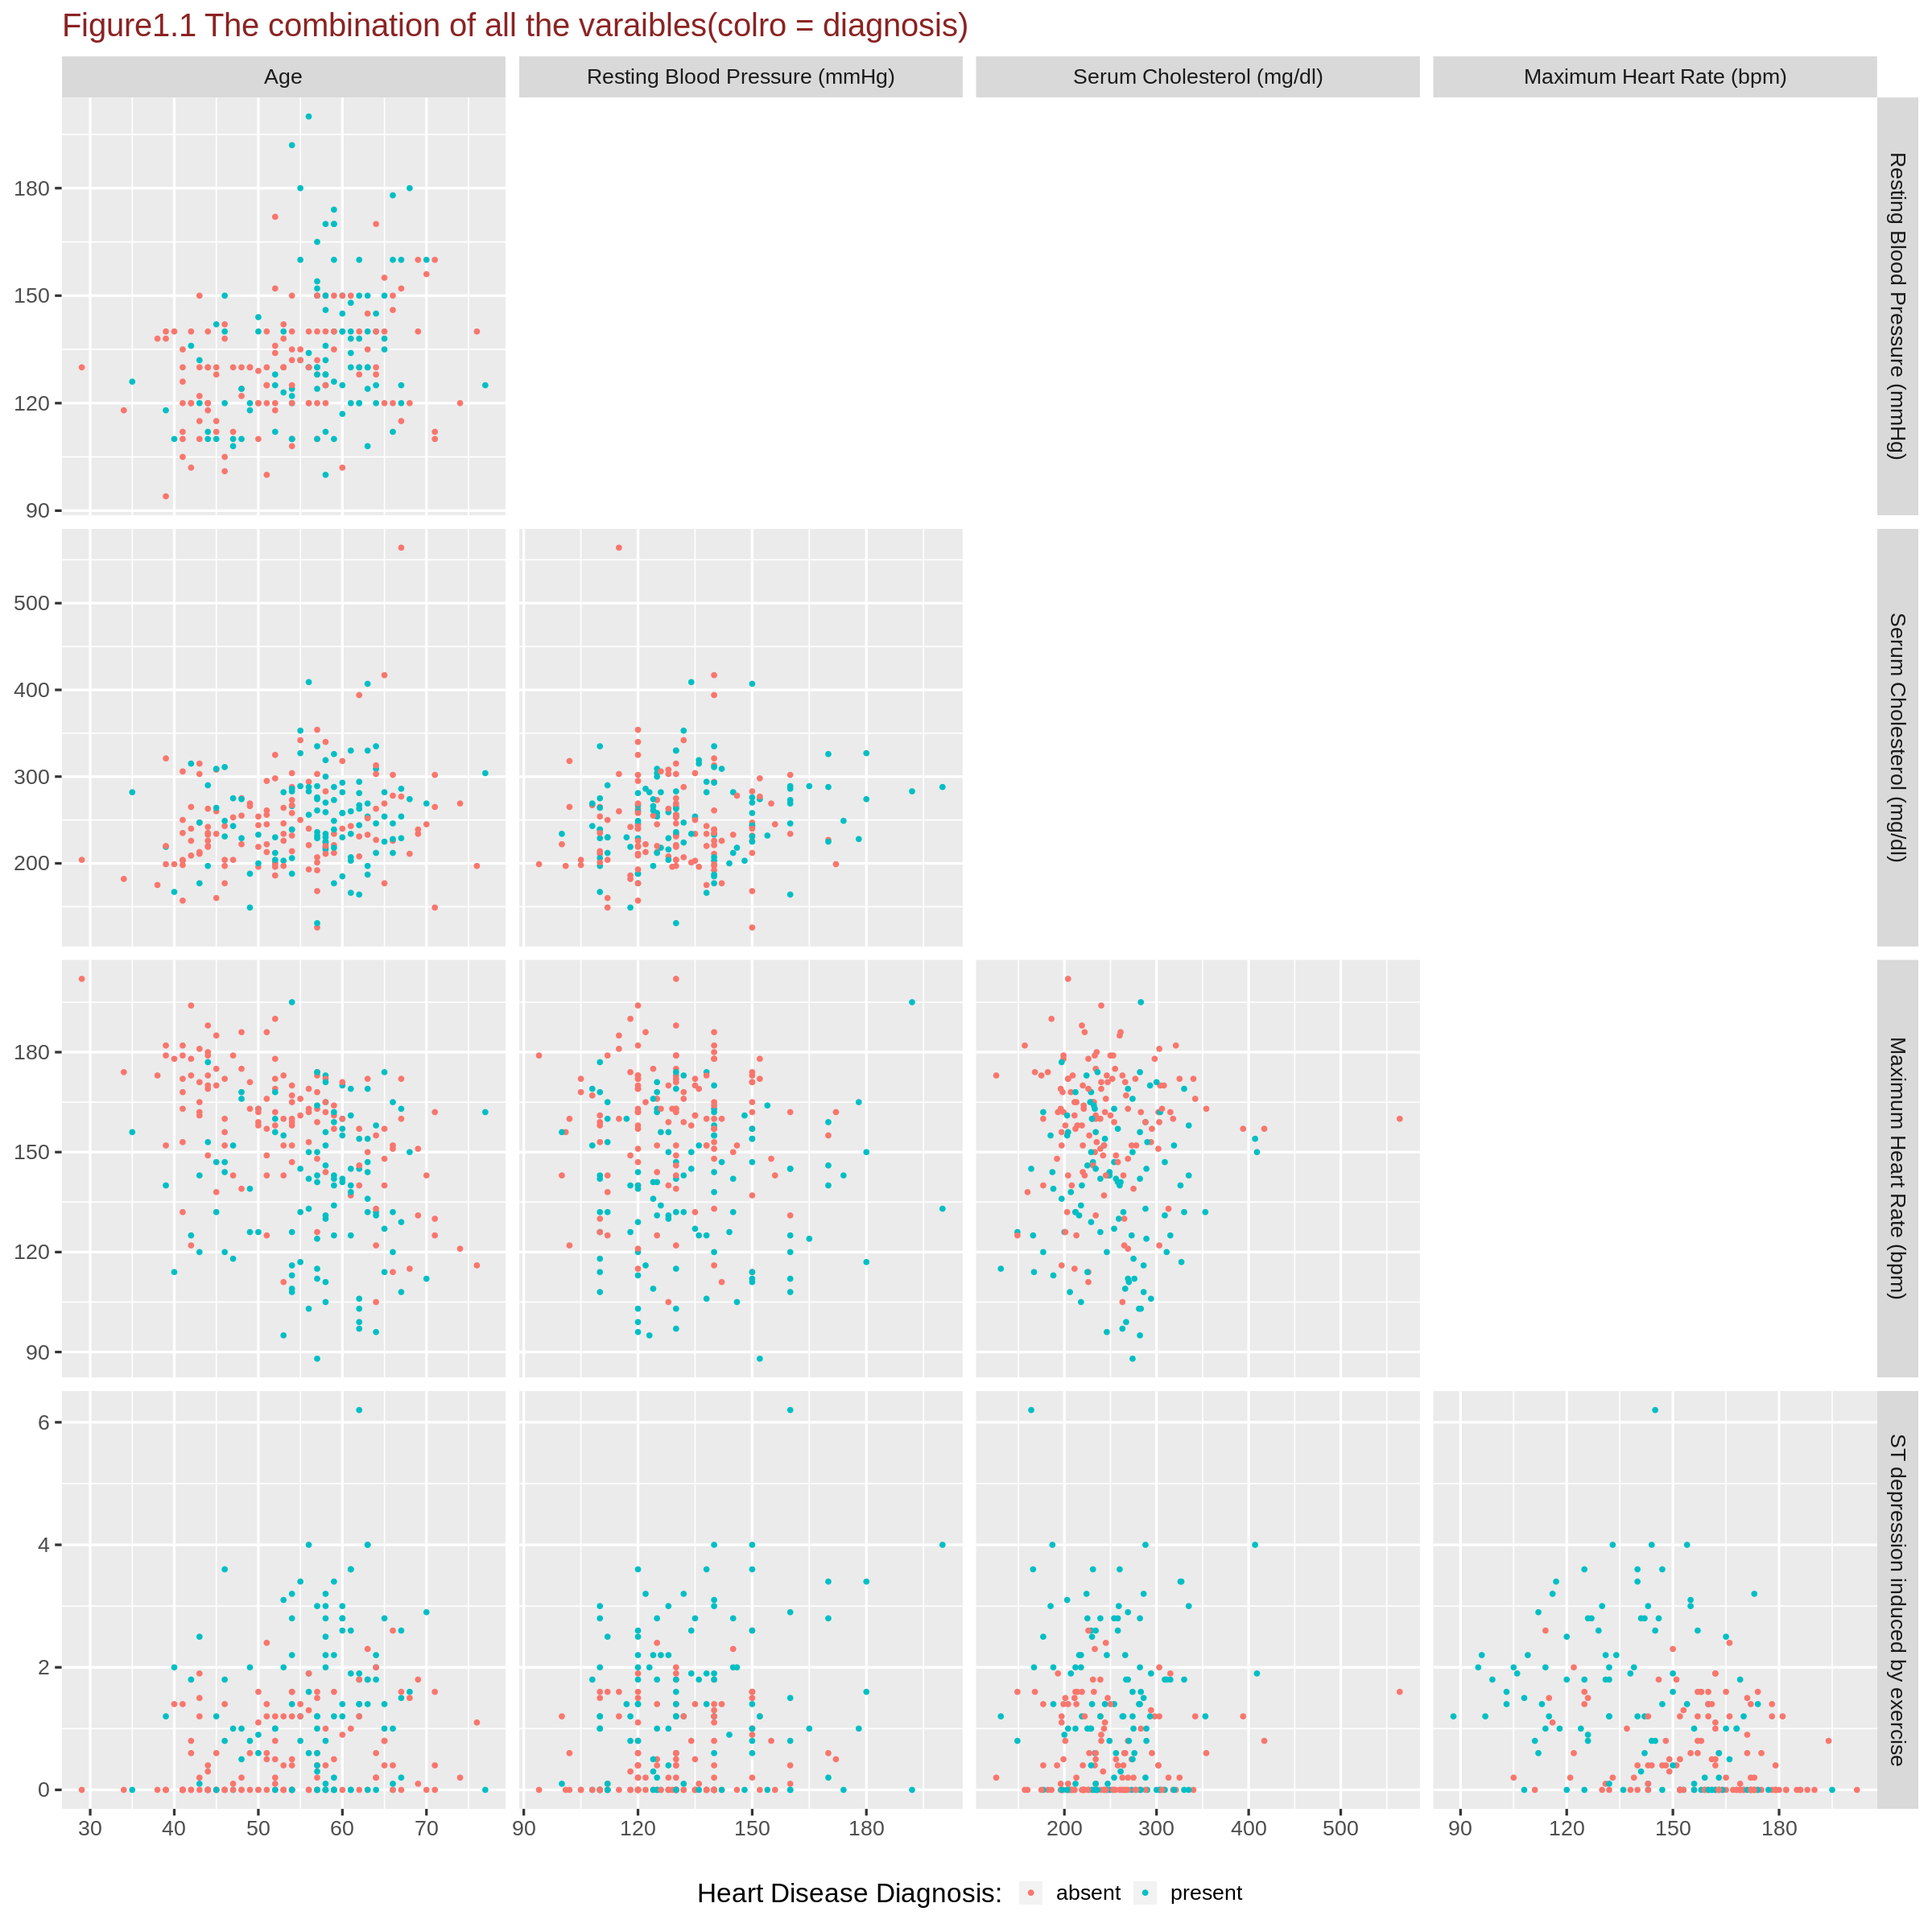

In [25]:
options(repr.plot.width = 20, repr.plot.height = 20) 

plot_pairs <- heart_train %>% 
  select(age, trestbps, chol, thalach, oldpeak, diagnosis) %>%
  ggpairs(legend = 6,
          columns = 1:5,
          mapping = ggplot2::aes(color = diagnosis),
          columnLabels = c("Age", "Resting Blood Pressure (mmHg)", "Serum Cholesterol (mg/dl)", "Maximum Heart Rate (bpm)", "ST depression induced by exercise"),
          diag = NULL,
          upper = "blank"
          ) +
          labs(color = "Heart Disease Diagnosis: ") +
          theme(axis.text.x = element_text(hjust = 1, color = "black", size = 20),
                axis.text.y = element_text(hjust = 1, color = "black", size = 20)) +
          theme_grey(base_size = 20)+
          theme(legend.position = "bottom")+
          labs(title = "Figure1.1 The combination of all the varaibles(color = diagnosis) ")+
         theme(plot.title = element_text(color = "brown4"))


# function to remove top most and right most row/column
gpairs_lower <- function(g){
  g$plots <- g$plots[-(1:g$nrow)]
  g$yAxisLabels <- g$yAxisLabels[-1]
  g$nrow <- g$nrow -1

  g$plots <- g$plots[-(seq(g$ncol, length(g$plots), by = g$ncol))]
  g$xAxisLabels <- g$xAxisLabels[-g$ncol]
  g$ncol <- g$ncol - 1

  g
}

gpairs_lower(plot_pairs)

### <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.2 Explanatory Variables vs. Heart Disease Diagnosis<a id='var-diag'></a>

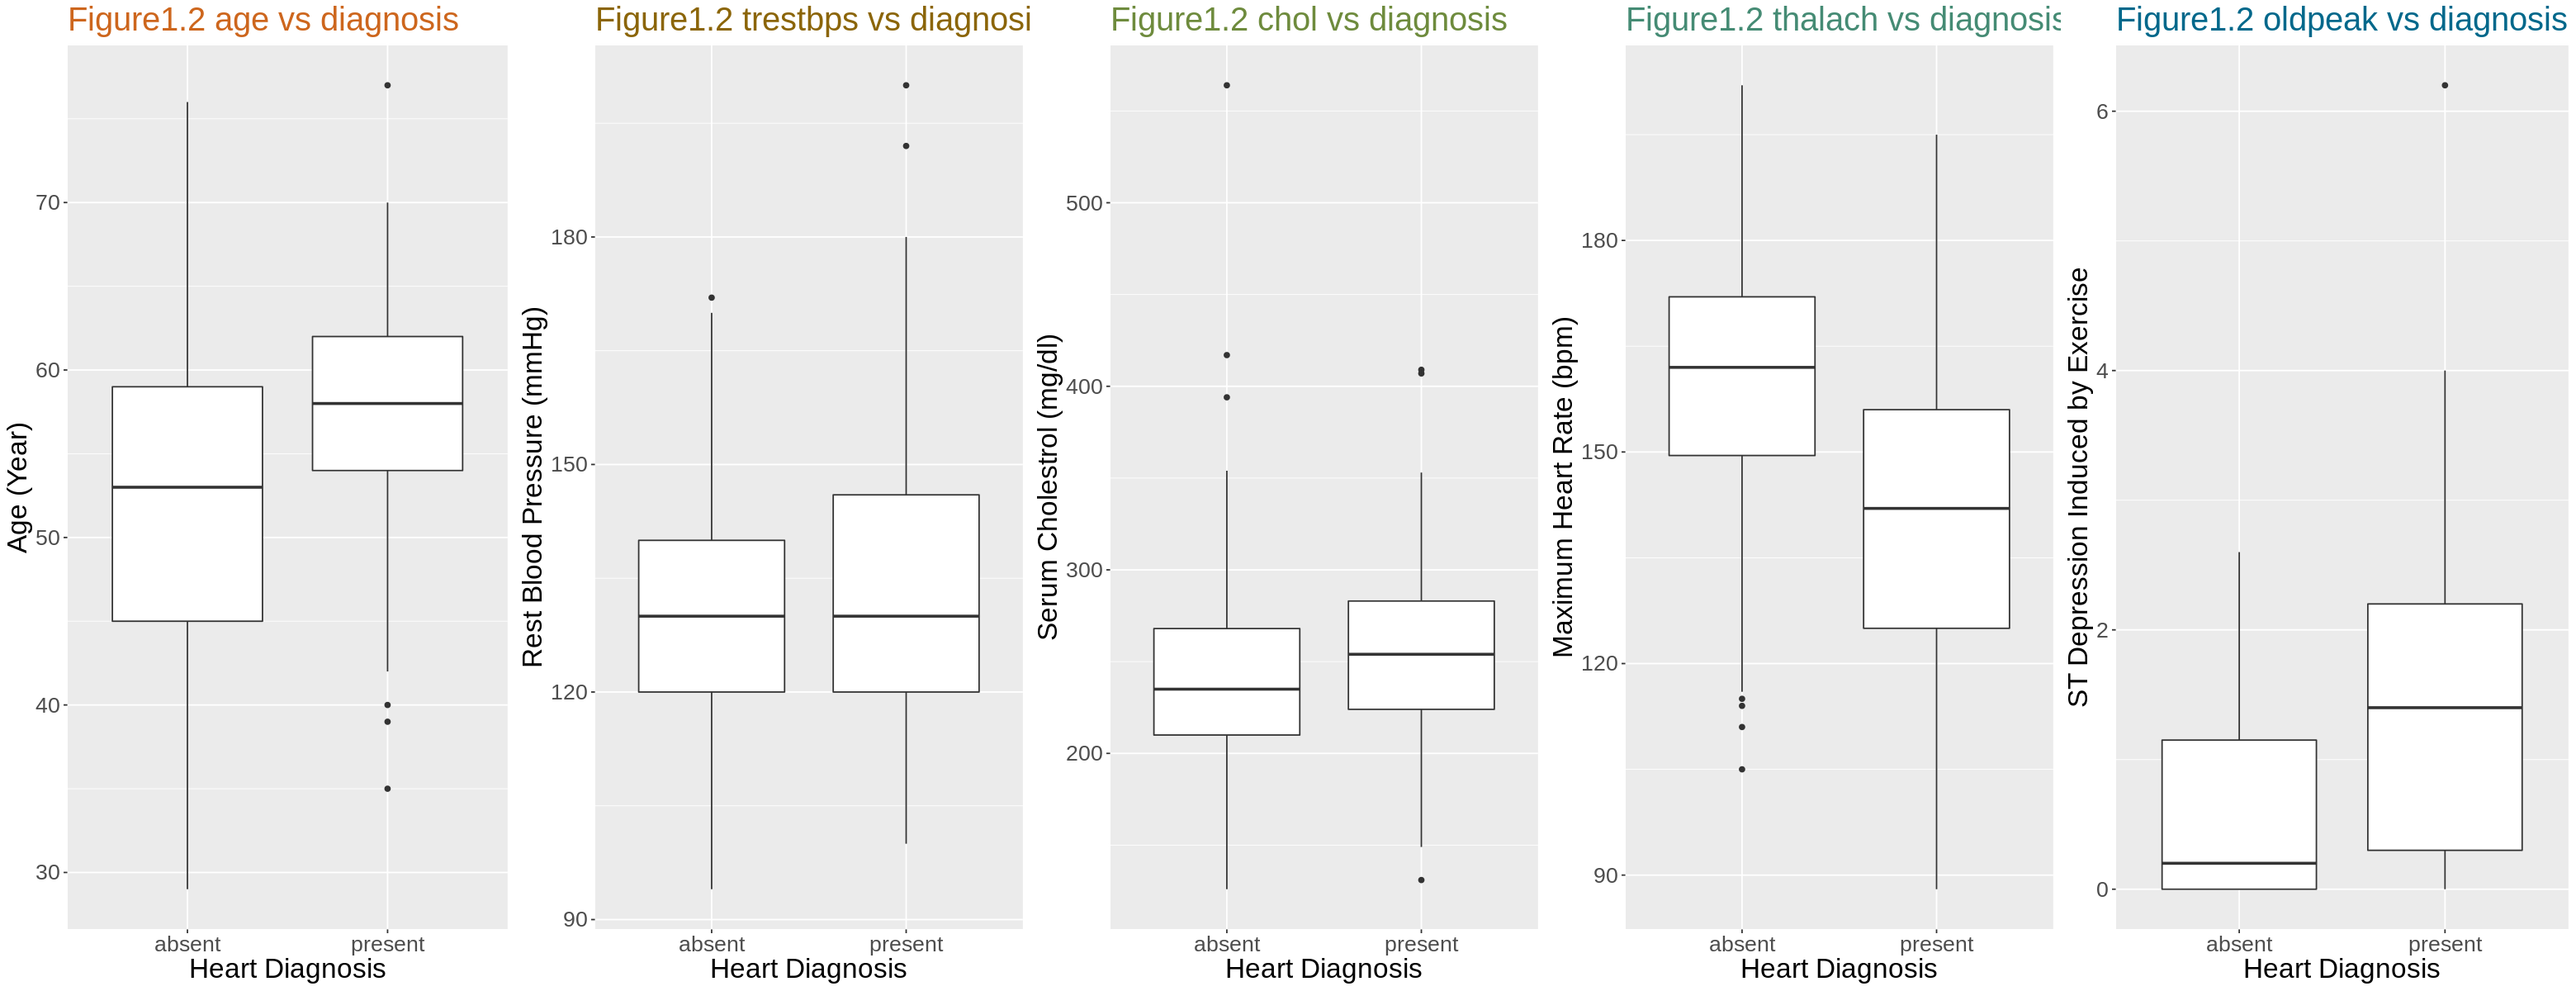

In [27]:
# age, trestbps, chol, thalach, oldpeak vs diagnosis

options(repr.plot.width = 26, repr.plot.height = 10)

age_diag_plot <- ggplot(heart_train,aes(y=age,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Age (Year)") +
    theme(text=element_text(size=20))+      
    labs(title = "Figure1.2 age vs diagnosis ")+
    theme(plot.title = element_text(color = "chocolate3"))



trestbps_diag_plot <- ggplot(heart_train,aes(y=trestbps,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Rest Blood Pressure (mmHg)") +
    theme(text=element_text(size=20))+          
    labs(title = "Figure1.2 trestbps vs diagnosis ")+
    theme(plot.title = element_text(color = "darkgoldenrod4"))


chol_diag_plot <- ggplot(heart_train,aes(y=chol,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Serum Cholestrol (mg/dl)") +
    theme(text=element_text(size=20))+
    labs(title = "Figure1.2 chol vs diagnosis ")+
    theme(plot.title = element_text(color = "darkolivegreen4"))


thalach_diag_plot <- ggplot(heart_train,aes(y=thalach,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Maximum Heart Rate (bpm)") +
    theme(text=element_text(size=20)) +                    
    labs(title = "Figure1.2 thalach vs diagnosis ")+
    theme(plot.title = element_text(color = "aquamarine4"))


oldpeak_diag_plot <- ggplot(heart_train,aes(y=oldpeak,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="ST Depression Induced by Exercise")+
    theme(text=element_text(size=20))+
    labs(title = "Figure1.2 oldpeak vs diagnosis ")+
    theme(plot.title = element_text(color = "deepskyblue4"))

combined_diag_plot <- grid.arrange(age_diag_plot,trestbps_diag_plot,chol_diag_plot,thalach_diag_plot,oldpeak_diag_plot, ncol = 5)
         


### <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.3 Analysis of Graphs<a id='analysis'></a>

In Figure 1.1, no strong relationships are seen between any two explanatory variables, so all explanatory variables meet the standard. In 2.3.2, as the presence of heart disease varies, the distribution of each variable is significantly different, which means all explanatory variables are related to the responsible variable. Therefore, all of the explanatory variables are chosen as predictors.

## <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/>2.4 Tuning the Classifier

In order to build our classification model, we need to use the tidy model's package's k nearest neighbors capacity and modify it to get the best value for the parameter k. (the number of neighbors considered in the class vote).

In [14]:
# Perform 10 folds Cross-Validation for heart_train dataset to choose appropriate k
set.seed(seed_num)
heart_10fold <- vfold_cv(heart_train, v=10, strata = diagnosis)

In [15]:
set.seed(seed_num)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

### 2.4.1 Chosing the predictors

We got a graph to campare the effects of different varaibles of the prediction. We used that graph to find the 3 varaibles to get the highest accuracy.

Firstly, we find all the possibilities of a different combination of predictors.

In [16]:
set_of_predictors <- c("age","trestbps","chol","thalach","oldpeak")

ps_predictors <- is.element("age",set_of_predictors)

powerset <- function(set) {
    ps <- list()
    set_length <- length(set)
    while (length(ps) < 2 ^ set_length - 1) {
        for(i in 1:set_length) {
            sample_i <- as.list(sample(set,i))
            t <- FALSE
            for(x in ps) {
                if(setequal(sample_i,x)) {
                   t <- TRUE
                }
            }
            if (t != TRUE) {
                ps <- append(ps,list(sample_i))
            }
        }
    }
    return(ps)
}

ps_predictors <- powerset(set_of_predictors)

ps_predictors #All combinations of the predictors



[[1]]
[[1]][[1]]
[1] "thalach"


[[2]]
[[2]][[1]]
[1] "trestbps"

[[2]][[2]]
[1] "oldpeak"


[[3]]
[[3]][[1]]
[1] "oldpeak"

[[3]][[2]]
[1] "thalach"

[[3]][[3]]
[1] "chol"


[[4]]
[[4]][[1]]
[1] "age"

[[4]][[2]]
[1] "oldpeak"

[[4]][[3]]
[1] "trestbps"

[[4]][[4]]
[1] "chol"


[[5]]
[[5]][[1]]
[1] "thalach"

[[5]][[2]]
[1] "trestbps"

[[5]][[3]]
[1] "chol"

[[5]][[4]]
[1] "oldpeak"

[[5]][[5]]
[1] "age"


[[6]]
[[6]][[1]]
[1] "thalach"

[[6]][[2]]
[1] "oldpeak"


[[7]]
[[7]][[1]]
[1] "thalach"

[[7]][[2]]
[1] "chol"

[[7]][[3]]
[1] "oldpeak"

[[7]][[4]]
[1] "age"


[[8]]
[[8]][[1]]
[1] "chol"


[[9]]
[[9]][[1]]
[1] "age"

[[9]][[2]]
[1] "chol"

[[9]][[3]]
[1] "trestbps"

[[9]][[4]]
[1] "thalach"


[[10]]
[[10]][[1]]
[1] "age"


[[11]]
[[11]][[1]]
[1] "chol"

[[11]][[2]]
[1] "trestbps"


[[12]]
[[12]][[1]]
[1] "age"

[[12]][[2]]
[1] "oldpeak"

[[12]][[3]]
[1] "thalach"


[[13]]
[[13]][[1]]
[1] "age"

[[13]][[2]]
[1] "thalach"

[[13]][[3]]
[1] "trestbps"

[[13]][[4]]
[1] "oldpeak"


[[14]]
[[14]][[1]]
[1] "age"

[[14]][[2]]
[1] "thalach"


[[15]]
[[15]][[1]]
[1] "chol"

[[15]][[2]]
[1] "trestbps"

[[15]][[3]]
[1] "age"


[[16]]
[[16]][[1]]
[1] "trestbps"

[[16]][[2]]
[1] "chol"

[[16]][[3]]
[1] "oldpeak"

[[16]][[4]]
[1] "thalach"


[[17]]
[[17]][[1]]
[1] "oldpeak"


[[18]]
[[18]][[1]]
[1] "chol"

[[18]][[2]]
[1] "age"


[[19]]
[[19]][[1]]
[1] "thalach"

[[19]][[2]]
[1] "age"

[[19]][[3]]
[1] "trestbps"


[[20]]
[[20]][[1]]
[1] "trestbps"


[[21]]
[[21]][[1]]
[1] "trestbps"

[[21]][[2]]
[1] "age"


[[22]]
[[22]][[1]]
[1] "age"

[[22]][[2]]
[1] "oldpeak"


[[23]]
[[23]][[1]]
[1] "chol"

[[23]][[2]]
[1] "oldpeak"


[[24]]
[[24]][[1]]
[1] "age"

[[24]][[2]]
[1] "chol"

[[24]][[3]]
[1] "thalach"


[[25]]
[[25]][[1]]
[1] "chol"

[[25]][[2]]
[1] "thalach"


[[26]]
[[26]][[1]]
[1] "oldpeak"

[[26]][[2]]
[1] "chol"

[[26]][[3]]
[1] "age"


[[27]]
[[27]][[1]]
[1] "oldpeak"

[[27]][[2]]
[1] "chol"

[[27]][[3]]
[1] "trestbps"


[[28]]
[[28]][[1]]
[1] "trestbps"

[[28]][[2]]
[1] "thalach"


[[29]]
[[29]][[1]]
[1] "thalach"

[[29]][[2]]
[1] "trestbps"

[[29]][[3]]
[1] "oldpeak"


[[30]]
[[30]][[1]]
[1] "trestbps"

[[30]][[2]]
[1] "oldpeak"

[[30]][[3]]
[1] "age"


[[31]]
[[31]][[1]]
[1] "trestbps"

[[31]][[2]]
[1] "chol"

[[31]][[3]]
[1] "thalach"

Secondly, we loop all the combinations to find out which one would get the highest Accuracy and what is the best k value for that combination.

In [ ]:
# We will use KNN Classification with 10 folds cross-validation for choosing the appropriate k value. The resulting accuracy will be calculated

heart_split <- initial_split(cleveland_data2, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

# Perform 10 folds Cross-Validation for heart_train dataset to choose appropriate k


heart_10fold <- vfold_cv(heart_train, v=10, strata = diagnosis)


knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

gridvals <- tibble(neighbors = seq(from = 1, to = 23))

Formula <- c()
K_value <- c()
Accuracy <- c()

for (combination in ps_predictors) {
    y <- "diagnosis ~"
    x <- combination[[1]]
    i <- 1
    while(i < length(combination)) {
        x <- paste(x, combination[[i+1]], sep = " + ") 
        i = i + 1
    }
    heart_formula <- as.formula(paste(y,x))
    
    
    
knn_recipe <- recipe(heart_formula, data = heart_train) %>% # Important !!!!!!!!!!!! Using only 3 predictors (chol,thalach, oldpeak) will gain the max accuracy
            step_center(all_predictors()) %>%
            step_scale(all_predictors())

heart_workflow <- workflow() %>%
                add_model(knn_spec) %>%
                add_recipe(knn_recipe)

heart_result <- heart_workflow %>%
                tune_grid(resamples = heart_10fold, grid = gridvals) %>%
                collect_metrics() 

accuracy <-  heart_result %>%
            filter(.metric == "accuracy") 


# accuracy_versus_k <- ggplot(accuracy, aes(x = neighbors, y = mean))+
#        geom_point() +
#        geom_line() +
#        labs(x = "Neighbors", y = "Accuracy Estimate") +
#        scale_x_continuous(breaks = seq(0, 23, by = 1)) +  # adjusting the x-axis
#        scale_y_continuous(limits = c(0.4, 1.0)) +# adjusting the y-axis 
#        theme(text=element_text(size=20))

# accuracy_versus_k

appropriate_k <- accuracy %>%
                arrange(-mean) %>%
                slice(1) %>%
                select(neighbors) %>%
                pull()

knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbor = appropriate_k) %>%
            set_engine("kknn") %>%
            set_mode("classification")

heart_fit <- workflow() %>%
                    add_model(knn_spec_new) %>%
                    add_recipe(knn_recipe) %>%
                    fit(data = heart_train)

heart_predictions <- predict(heart_fit, heart_test) %>%
                    bind_cols(heart_test)

heart_metrics <- heart_predictions %>% 
    metrics(truth = diagnosis, estimate = .pred_class)

heart_conf_mat <- heart_predictions %>%
    conf_mat(truth =diagnosis, estimate = .pred_class)

# print(heart_formula)    
Formula <- append(Formula,heart_formula)
#print(paste("Appropriate k =", appropriate_k))
K_value <- append(K_value, appropriate_k)  
# print(heart_metrics)
accuracy_val <- heart_metrics %>%
            filter(.metric == "accuracy") %>%
            select(.estimate) %>%
            pull()
Accuracy <- append(Accuracy,accuracy_val)
            
# heart_conf_mat
}

In [ ]:
set.seed(seed_num)
heart_subset <- heart_train %>% 
  select(age, 
         trestbps, 
         chol, 
         thalach, 
         oldpeak, 
         diagnosis)

names <- colnames(heart_subset %>% select(-diagnosis))

accuracies <- tibble(size = integer(),
                    model_string = character(),
                    accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 10-fold cross-validation object
heart_xfold <- vfold_cv(heart_train, v = 10, strata = diagnosis)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("diagnosis", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_train) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(heart_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = heart_xfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

In [ ]:
selected_predictors <- accuracies %>%
                arrange(-accuracy) %>%
                slice(1)
#                 select(model_string) %>%
#                 pull()
selected_predictors


### 2.5 Tuning the Classifier
We start by assigning the tune() function to the parameter value k in the knn classification model specification we'll use for tuning. Then weset up a range of 1 -23 to test wich is the best value for k in this range,so we plot the accuracy values against k values to find the most optimal value for the parameter k.  


In a workflow, we connect our model specification with the scaling formula that was previously defined. Then, the tune grid function fits the model to each value in our parameter range.

In [ ]:
nrow(heart_train)

In [34]:
#graph of different accuracy
knn_recipe <- recipe(diagnosis ~ thalach + oldpeak, data = heart_train) %>% # Important !!!!!!!!!!!! Using only 3 predictors (chol,thalach,oldpeak) will gain the max accuracy
            step_center(all_predictors()) %>%
            step_scale(all_predictors())

heart_workflow <- workflow() %>%
                add_model(knn_spec) %>%
                add_recipe(knn_recipe)

# warning - long run time with 1-23
gridvals <- tibble(neighbors = seq(from = 1, to = 23))

heart_result <- heart_workflow %>%
                tune_grid(resamples = heart_10fold, grid = gridvals) %>%
                collect_metrics() 

accuracy <-  heart_result %>%
            filter(.metric == "accuracy") 

In [ ]:
options(repr.plot.width=10, repr.plot.height=7)
# accuracy
accuracy_versus_k <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 40, by = 2)) + # adjusting the x-axis
       scale_y_continuous(limits = c(0.55, 0.75)) + # adjusting the y-axis 
       theme(text=element_text(size = 20)) +
       theme_classic(base_size = 14)+
       labs(title = "Figure2.1 Accuracy for different k value ",subtitle = "mean vs neighbors")+
       theme(plot.title = element_text(color = "darkorchid4"))

accuracy_versus_k


We extract the number of neighbors associated with the highest accuracy estimate and save that value as appropriate_k. We can also visually see that the accuracy of the model peaks around K = 23 which provides a high accuracy model and changing the K value to a nearby one doesn’t decrease accuracy too much, so that our choice is reliable in the presence of uncertainty. 

In [ ]:
appropriate_k <- accuracy %>%
                arrange(-mean) %>%
                slice(1) %>%
                select(neighbors) %>%
                pull()
appropriate_k


## Using the Model

As the result above shown that the model could get the highest accuracy would be :

**A KNN-classification model with thalach and oldpeak as the predictors with k value equals 23**


### 2.6 Training the Classifier
Next, we create our final model specification using appropriate_k as the number of nearest neighbors and fit the model to our training set to create our finalized classifier.

In [ ]:
set.seed(seed_num)
# final model specification
knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbor = appropriate_k) %>%
            set_engine("kknn") %>%
            set_mode("classification")

# workflow
heart_fit <- workflow() %>%
                    add_model(knn_spec_new) %>%
                    add_recipe(knn_recipe) %>%
                    fit(data = heart_train)

### 2.7 Predicting the Testing Set
We use our finalized trained KNN classfication model to predict heart disease in patients in our testing set. We then bind the predictions produced by our model with the original testing set, so that we can compare our predictions to the true class values.

In [ ]:
heart_predictions <- predict(heart_fit, heart_test) %>%
                    bind_cols(heart_test)
head(heart_predictions)


## 3. Results
Comparing the predictions of our KNN classfication model on the testing data to the actual value, we can evaluate our model's performance by calculating the overall accuracy of our model's predictions. We achieve a final accuracy rate of 80%.

In [ ]:
heart_summary <- heart_predictions %>%
                  metrics(truth = diagnosis, estimate = .pred_class) %>%
                  filter(.metric == "accuracy")

heart_accuracy <- heart_summary %>%
                select(.estimate) %>%
                pull()

paste(round(heart_accuracy*100,2), "%")


We also put the prediction results into a confusion matrix comparing with the actual results, this allow us to see how many false positives and false negatives our models gave.

In [ ]:
heart_conf_mat <- heart_predictions %>%
    conf_mat(truth =diagnosis, estimate = .pred_class)

heart_conf_mat

Our model gave 4 false positives and 13 false negatives. This might not be a very good model to use in a medical field as false negatives may lead to a misdiagnosis of heart disease and patient will not be treated in time for their condition. However, our model produced a relatively low number of false positives. This could be good in a medical perspective in that not a lot of patients will have to go through additional invasive tests uneccessarily. 

## Discussion

After tidying our data, we trained our model to perform KNN classification and found the best value of K to be 13. Using the forward selection technique in R, we found the predictors “ST depression induced by exercise relative to rest” (oldpeak) and “maximum heart rate” (thalach) have the highest accuracy. Using the two predictors, we can confidently predict the presence of heart disease in patients in our testing data set with an accuracy score of 80%.

According to previous research, ST depression caused after exercise is known to detect heart disease with a sensitivity of about 75% (Bobbio, 1992). Sensitivity, in a medical sense, is important because it measures the ability of a test to detect disease in patients correctly. Our model has a sensitivity of 90.2%; therefore, it can better predict heart disease using ST depression and maximum heart rate than ST depression alone. Furthermore, after graphing maximum heart rate against the presence or absence of heart disease, we saw a trend that a lower maximum heart rate is a predictor of heart disease. With those results, we expected that maximum heart rate would be a predictor for diagnosis, which our model agrees with.  

Our model allows us to use low maximum heart rate and ST depression as heart disease markers, which can benefit and save many lives. By understanding these predictors, we can potentially use them in the future for diagnosing heart disease. Future questions may lead to ways of improving accuracy using these two predictors. For example, suppose this model is reproducible with larger datasets and has a high accuracy score. In that case, it can be a potential screening tool for heart disease patients before any invasive procedures for diagnosis. Additionally, potential next steps can expand on genetic and environmental factors that influence the predictors for the presence of heart disease. It could also lead to questions that explore the prevention, allowing for more opportunities for healthier lifestyles.  

**Future questions this could lead to are:**  
1. What internal and external factors influence ST depression and maximum heart rate? 
2. Are there other variables within the Heart Disease dataset that are also predictors with good accuracy of heart disease?
3. In what ways can we prevent ST depression and low maximum heart rate? How effective are the methods of prevention?


## References
Abi-Mansour, P., Bobbio, Colombo, A., M., Deckers, J.W., Detrano, R., Guppy, K.H., Janosi, A., Lehmann, K.G., Olson, H.G., Pfisterer, M., Righetti, A., Schmid, J., Steinbrunn, W. (1992). Exercise-induced ST depression and ST/heart rate index to predict triple-vessel or left main coronary disease: A multicenter analysis. Journal of the American College of Cardiology, 19(1), 11-18. https://doi.org/10.1016/0735-1097(92)90044-N
 
Calling, S., Johansson, S. E., Sundquist, J., Sundquist, K., Wolff, M. (2021). Total cholesterol/HDL-C ratio versus non-HDL-C as predictors for ischemic heart disease: a 17-year follow-up study of women in southern Sweden. BMC cardiovascular disorders, 21(1), 163. https://doi.org/10.1186/s12872-021-01971-1
 
 
UCI Machine Learning Repository. (1988). Heart Disease Data Set [Data file]. Retrieved from https://archive.ics.uci.edu/ml/datasets/Heart+Disease
